In [1]:
%reload_ext autoreload
%autoreload 2

## Algoritmos Evolutivos 1
### Carrera de Especialización en Inteligencia Artificial - FIUBA

### Trabajo Final

### 5º Bimestre 2025

### Grupo

| Autores               | E-mail                    | Nº SIU  |
|---------------------- |---------------------------|---------|
| Braian Desía          | b.desia@hotmail.com       | a1804   |

## MSTGAM-4trading

### 1. DESCRIPCIÓN DEL DESAFÍO

Se presenta la implementación de un **sistema de trading algorítmico** optimizado mediante un **Algoritmo Genético (GA)**, diseñado específicamente para la agregación y priorización de recomendaciones procedentes de múltiples estrategias de trading basadas en el paradigma de *Directional Changes* (DC) con distintos umbrales de detección de cambios direccionales.

El objetivo principal es desarrollar un marco de decisión robusto capaz de generar señales óptimas de inversión (buy, sell o hold) en mercados de acciones, combinando de forma inteligente las recomendaciones de ocho estrategias de trading DC-based, cada una perfilada bajo diez umbrales diferentes (θ). Este enfoque multi-estrategia y multi-umbral permite capturar una visión más completa y granular de la dinámica del mercado, superando las limitaciones de los enfoques tradicionales basados en tiempo físico fijo o en un único umbral DC. El Algoritmo Genético propuesto optimiza los pesos y prioridades de las sub-estrategias individuales, resolviendo conflictos entre señales contradictorias y maximizando el rendimiento ajustado al riesgo sin requerir suposiciones previas sobre el comportamiento del mercado.

### 2. IMPLEMENTACIÓN

#### 2.2 LIBRERÍAS

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

from main import DCTrader, Backtest, DCTracker
from trainer import GATrainer, PSOTrainer

#### 2.3 MODEL DEFINITION

In [3]:
from strategies import St1, St2, St3, St4, St5, St6, St7, St8

ticker = 'AAPL'

thresholds = [0.00098, 0.0022, 0.0048, 0.0072, 0.0098, 0.0122, 0.0155, 0.017, 0.02, 0.0255]
strategies = [St1, St2, St3, St4, St5, St6, St7, St8]

# Modo entrenamiento (precomputa estados)
trader = DCTrader(
    ticker=ticker,
    thresholds=thresholds,
    strategies=strategies,
    is_train=True,
    start_date='2016-01-01',
    end_date='2024-01-01'
)

print(f"Trader creado para {ticker}")
print(f"Thresholds: {thresholds}")
print(f"Datos cargados: {len(trader.prices)} días")

AAPL: 2012 loaded days | 2016-01-04 to 2023-12-29
Trader creado para AAPL
Thresholds: [0.00098, 0.0022, 0.0048, 0.0072, 0.0098, 0.0122, 0.0155, 0.017, 0.02, 0.0255]
Datos cargados: 2012 días


#### 2.3.1 ENTRENAMIENTO

Se emplea el módulo `GATrainer`, que implementa un **algoritmo genético (GA) clásico basado en DEAP** para optimizar los pesos del ensemble de estrategias.

##### Representación del individuo (cromosoma)
- Cada individuo es un vector de valores reales en el intervalo `[0, 1]`.
- La longitud del vector corresponde al número total de combinaciones (estrategia + threshold) definido en `combination_matrix`:
  - Estrategias **St1–St6**: hasta 10 thresholds cada una.
  - Estrategias **St7–St8**: máximo 5 thresholds cada una (para evitar overfitting en patrones históricos largos).
- Los pesos se organizan en una matriz `weights[n_strats, n_ths]` y se **normalizan por fila** (por estrategia), garantizando que la suma de pesos para cada estrategia sea 1.

##### Función de fitness
Maximiza un **Sharpe Ratio ajustado** con la siguiente fórmula:

$$
\text{fitness} = \text{SR} 
- 0.8 \times \max(0, \text{ToR} - 0.002)
+ 
\begin{cases} 
0.1 \times \min(\text{RoR}, 1.0) & \text{si } \text{RoR} > 0 \\
0 & \text{en caso contrario}
\end{cases}
$$

Donde:
- **SR**: Sharpe Ratio
- **ToR**: Turnover Rate
- **RoR**: Rate of Return (rentabilidad)

- Se aplica una penalización fuerte si el número de trades es menor a 10 o si la volatilidad es casi nula (evita soluciones triviales como "hold forever").
- **Objetivo**: obtener un alto Sharpe Ratio con bajo riesgo y turnover controlado, alineado exactamente con los criterios del paper.

##### Operadores evolutivos
- **Inicialización**: Valores uniformes en `[0, 1]`.
- **Crossover**: Blend crossover (`cxBlend`, alpha=0.5) con probabilidad `cxpb=0.95` (ajustable).
- **Mutación**: Gaussiana (`mutGaussian`, σ=0.2) con probabilidad por gen `indpb=0.1`, valores clipped a `[0, 1]`.
- **Selección**: Torneo (`selTournament`, tamaño por defecto 2–3).
- **Reemplazo**: Elitismo implícito mediante `HallOfFame` (preserva el mejor individuo).

##### Proceso de entrenamiento
1. Crea una población inicial (por defecto 150 individuos).
2. Evalúa cada individuo mediante un backtest completo del ensemble.
3. Aplica selección → crossover → mutación → re-evaluación.
4. Reporta progreso cada 10 generaciones: SR, RoR, ToR, número de trades y fitness actual.
5. Tras completar `n_gen` generaciones (por defecto 50–80), asigna los pesos del mejor individuo al trader.
6. Guarda el modelo entrenado en formato `.pkl` con los pesos óptimos, thresholds y metadata.

##### Hiperparámetros por default (ajustables en `fit()`)
- `pop_size`: 150.
- `n_gen`: 50.
- `cxpb`: Alta (0.95) → favorece una fuerte recombinación.
- `mutpb`: Baja-moderada (0.05) → preserva esquemas prometedores.

In [7]:
trader.fit()

Iniciando entrenamiento GA | Población: 150 | Generaciones: 50
Número total de pesos a optimizar: 70
Gen   1 | SR: -0.016 | RoR: -0.212 | ToR: 0.16402 | Trades: 330 | Fit: -0.163
Gen  10 | SR: -0.002 | RoR: -0.111 | ToR: 0.15755 | Trades: 317 | Fit: -0.124
Gen  20 | SR: 0.066 | RoR: 0.437 | ToR: 0.13668 | Trades: 275 | Fit: -0.007
Gen  30 | SR: 0.112 | RoR: 0.799 | ToR: 0.09990 | Trades: 201 | Fit: 0.124
Gen  40 | SR: 0.109 | RoR: 0.729 | ToR: 0.10040 | Trades: 202 | Fit: 0.124
Gen  50 | SR: 0.172 | RoR: 1.670 | ToR: 0.11332 | Trades: 228 | Fit: 0.157

ENTRENAMIENTO GA COMPLETADO EXITOSAMENTE
Mejor fitness (Sharpe ajustado): 0.1568
Sharpe Ratio puro final     : 0.1291
RoR acumulado final         : 1.003
Trades totales              : 226
Turnover Rate final         : 0.11233
Modelo guardado correctamente en: ../persistency/AAPL_model.pkl


Se observa que el SR asi como el RoR aumentan conforme se avanza en las generaciones.

Evaluamos cuales son los pesos de cada par (strategia, threshold). Esto nos permite ver que combinaciones son más eficiente.

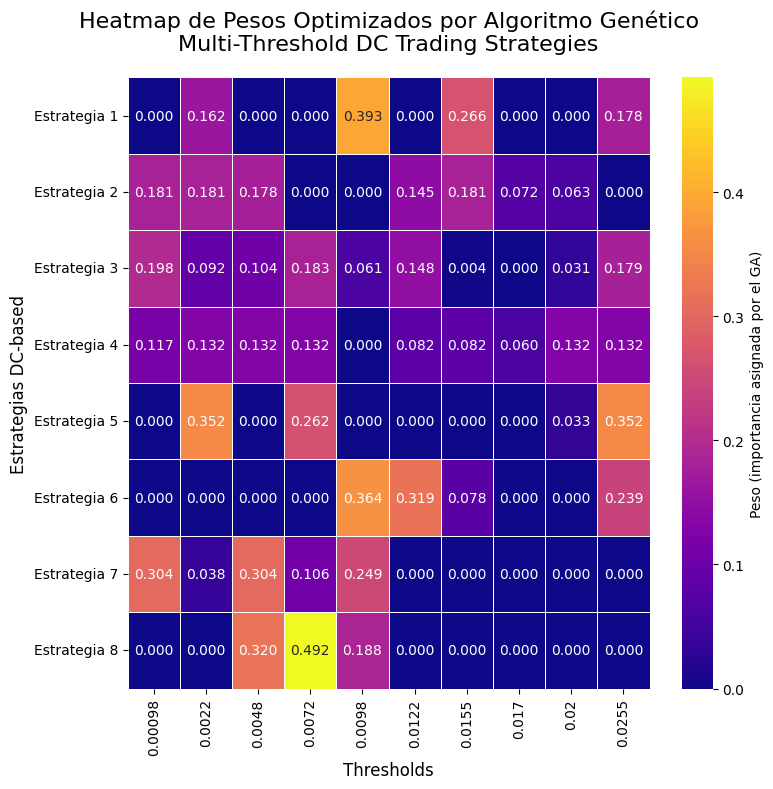

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

best_weights = trader.weights

# Configuración del heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(
    trader.weights,
    annot=True,
    fmt='.3f',
    cmap='plasma',
    linewidths=.5,
    linecolor='white',
    cbar_kws={'label': 'Peso (importancia asignada por el GA)'},
    xticklabels=thresholds,
    yticklabels=[f'Estrategia {i+1}' for i in range(8)]
)

plt.title('Heatmap de Pesos Optimizados por Algoritmo Genético\n'
          'Multi-Threshold DC Trading Strategies',
          fontsize=16, pad=20)
plt.xlabel('Thresholds', fontsize=12)
plt.ylabel('Estrategias DC-based', fontsize=12)
plt.tight_layout()
plt.show()

#### 2.4 EVALUACIÓN

           RoR     STD      SR     VaR     ToR  Trades
MSTGAM  0.9516  0.0265  0.1252 -0.0449  0.1123   226.0


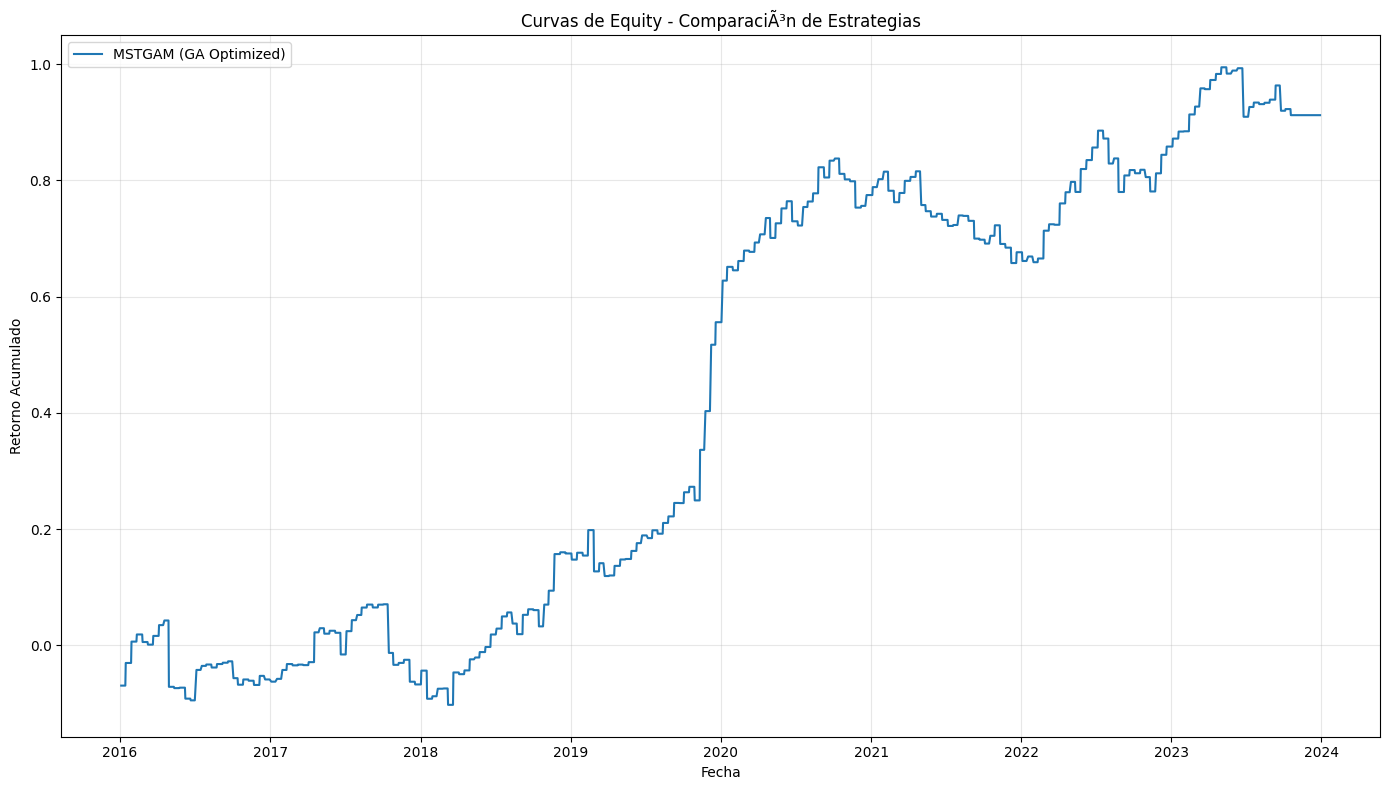

In [40]:
backtest = Backtest(trader)
print(backtest.compare_metrics(['MSTGAM']))
backtest.plot_equity_curves(['MSTGAM'])

### 3 CONCLUSIONES

- Se presento un enfoque de trading basado en Cambios Direccionales.
- El modelo se basa en el ensamble de la recomendación de diversas estrategias.
- El peso del voto de cada uno se optimzó utilizando algoritmos genéticos con el fin de maximizar el Sharpe Ratio.

#### 3.1 TRABAJOS FUTUROS

1. Optimización conjunta de pesos y thresholds
- Extender el cromosoma del algoritmo genético (GA) para incluir **valores de thresholds dinámicos o adaptativos por estrategia**.
- En lugar de usar un conjunto fijo de 10 thresholds predefinidos, evolucionar simultáneamente un vector de valores θ óptimos (o rangos) junto con los pesos del ensemble.

2. Genetic Programming (GP) para la evolución de nuevas estrategias DC-based
- Sustituir o complementar el GA actual por **Genetic Programming (GP)** para generar automáticamente nuevas reglas de trading a partir de primitivas del paradigma DC (OSV, TMV, rd, rn, patrones históricos, duración de overshoot/DC, etc.).
- Los árboles de GP combinarían indicadores DC existentes con operadores lógicos y aritméticos, permitiendo la creación automática de estrategias St9, St10, etc.

3. Optimización multi-objetivo
- Pasar del objetivo único actual (Sharpe Ratio ajustado) a una formulación **multi-objetivo** que maximice RoR y SR mientras minimiza Drawdown, Turnover Rate (ToR) y VaR simultáneamente.
- Obtener un **frente de Pareto** que ofrezca soluciones con diferentes trade-offs (alto retorno/bajo riesgo vs bajo turnover/alta estabilidad).